# Submission 3

We have selected following data for our analysis:
Hang Seng Investment Index Funds Series II - Hang Seng Index ETF traded on HKSE in Hong Kong dollar.
SPDR Gold ETF(GLD) traded on Nasdaq in USD.
Bitcoin in USD.
Data source: Yahoo Finance website.
Time Frame: Jan to Dec-2020

In [86]:
# !pip install copulalib

  Created wheel for copulalib: filename=copulalib-1.1.0-py3-none-any.whl size=15495 sha256=7702ab1a8b62e873a0065ca5ad7c3df57afd726b827825326efbe7a7db33a8c6
  Stored in directory: c:\users\admin\appdata\local\pip\cache\wheels\8b\7f\fe\02801e0af7b7fe6ec7b7b45bbd3ff9f46867426fa94f75b0f0
Successfully built copulalib


In [4]:
import arch
import holidays
import pandas as pd
import numpy as np
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.tsa.vector_ar.vecm import VECM
from sklearn import preprocessing
from scipy import stats
from datetime import datetime
from statsmodels.tsa.stattools import adfuller, coint # for ADF and Cointegration
from statsmodels.tsa.vector_ar.vecm import VECM
from sklearn.cluster import DBSCAN
from pandas import Series, DataFrame
from scipy.stats import kurtosis
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Dataset Importing, Processing, Summaries and Extreme Values

In [5]:
gld_df = pd.read_csv("sub2/GLD.csv")
ety_df = pd.read_csv("sub2/2833.HK.csv")
btc_df = pd.read_csv("sub2/BTC-USD.csv")

In [6]:
def dtindex(df):
    df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m-%d")
    df.set_index("Date", inplace=True)   
    return df

In [7]:
def apr_index(df):
    return df.loc[df.index > "2020-03-31"]

In [8]:
gld_df = dtindex(gld_df)
ety_df = dtindex(ety_df)
btc_df = dtindex(btc_df)

In [9]:
# taking April to December Dataset
gld_df = apr_index(gld_df)
ety_df = apr_index(ety_df)
btc_df = apr_index(btc_df)

In [10]:
gld_df.fillna(gld_df.mean(), inplace=True)
ety_df.fillna(ety_df.mean(), inplace=True)
btc_df.fillna(btc_df.mean(), inplace=True)

In [11]:
gld_df.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-04-01,148.199997,150.080002,147.850006,149.449997,149.449997,11827400
2020-04-02,151.199997,152.500000,150.699997,151.899994,151.899994,9188300
2020-04-03,152.229996,153.089996,151.660004,152.649994,152.649994,8469100
2020-04-06,154.160004,157.220001,153.960007,156.880005,156.880005,14739300
2020-04-07,155.330002,156.139999,154.380005,156.039993,156.039993,9195400


In [12]:
index1 = set(ety_df.index)
index2 = set(gld_df.index)
gap = index1-index2
len(index1), len(index2), len(gap)

(185, 190, 4)

In [13]:
def consis_index(df, indices, missing):
    return df.loc[[index for index in indices if index not in missing]]

In [14]:
gld_df = consis_index(gld_df, ety_df.index, gap)
ety_df = consis_index(ety_df, ety_df.index, gap)
btc_df = consis_index(btc_df, ety_df.index, gap)

In [15]:
len(gld_df), len(ety_df), len(btc_df)

(181, 181, 181)

In [16]:
# Daily Log Return
ety_df['Day_Return'] = np.log(ety_df['Adj Close']) - np.log(ety_df['Adj Close'].shift(1))
gld_df["Day_Return"] = np.log(gld_df['Adj Close']) - np.log(gld_df['Adj Close'].shift(1))
btc_df["Day_Return"] = np.log(btc_df['Adj Close']) - np.log(btc_df['Adj Close'].shift(1))

In [17]:
gld_df.fillna(gld_df.mean(), inplace=True)
ety_df.fillna(ety_df.mean(), inplace=True)
btc_df.fillna(btc_df.mean(), inplace=True)

In [18]:
ety_df.head()

,Open,High,Low,Close,Adj Close,Volume,Day_Return
Date,,,,,,,
2020-04-01,24.299999,24.400000,23.549999,23.600000,23.600000,116900,0.000870
2020-04-02,23.450001,23.799999,23.299999,23.799999,23.799999,54400,0.008439
2020-04-03,23.900000,23.900000,23.500000,23.650000,23.650000,46400,-0.006322
2020-04-06,23.900000,24.350000,23.850000,24.299999,24.299999,57400,0.027113
2020-04-07,24.500000,24.850000,24.350000,24.799999,24.799999,138229,0.020367


In [19]:
# Kurtosis for each return series

print("Kurtosis for Equity Returns is:",kurtosis(ety_df["Day_Return"].dropna()))
print("Kurtosis for Gold Returns is:",kurtosis(gld_df["Day_Return"].dropna()))
print("Kurtosis for Bitcoin Returns is:",kurtosis(btc_df["Day_Return"].dropna()))

Kurtosis for Equity Returns is: 2.3720158916024063
Kurtosis for Gold Returns is: 3.9663292288385605
Kurtosis for Bitcoin Returns is: 41.87653604709551


In [20]:
# Identifying Extreme Value using DBscan

Ext_Ety = pd.concat([ety_df['Close'], ety_df['Day_Return']], axis=1, keys=['Close', 'Day_Return']).fillna(0).values
Ext_Gld = pd.concat([gld_df['Close'], gld_df['Day_Return']], axis=1, keys=['Close', 'Day_Return']).fillna(0).values
Ext_Btc = pd.concat([btc_df['Close'], btc_df['Day_Return']], axis=1, keys=['Close', 'Day_Return']).fillna(0).values

In [21]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

def dbscan(X, eps, min_samples):
    ss = StandardScaler()
    X = ss.fit_transform(X)
    db = DBSCAN(eps=eps, min_samples=min_samples)
    db.fit(X)
    y_pred = db.fit_predict(X)
    plt.scatter(X[:,0], X[:,1],c=y_pred, cmap='Paired')
    plt.title("DBSCAN")

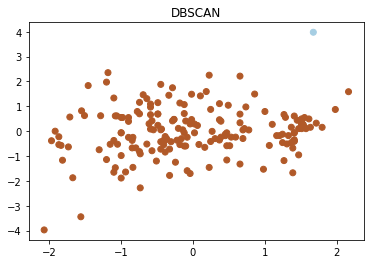

In [22]:
dbscan(Ext_Ety, eps=1.7, min_samples=2)

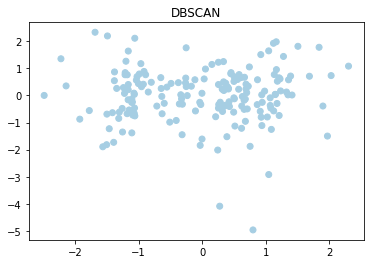

In [23]:
dbscan(Ext_Gld, eps=1.7, min_samples=2)

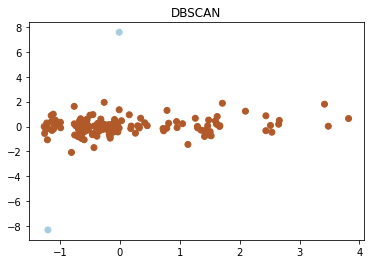

In [24]:
dbscan(Ext_Btc, eps=1.7, min_samples=2)

In [25]:
## From DBScans we can see that Equity and Bitcoins shows extreme values

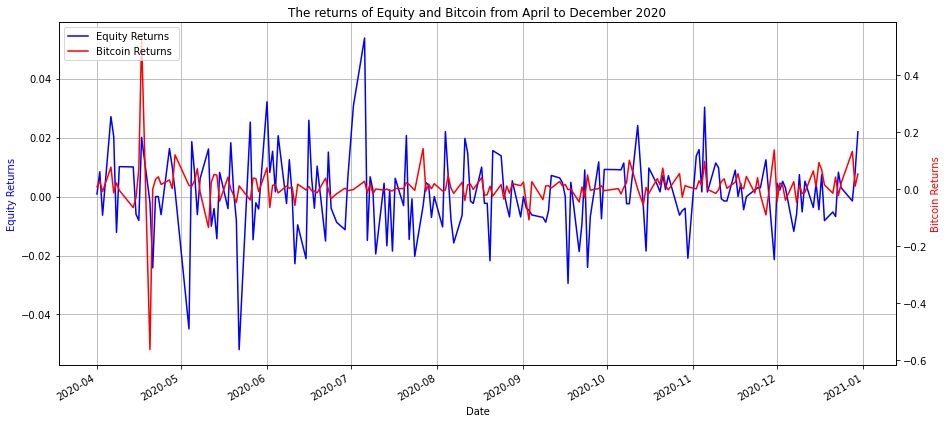

In [26]:
plt.figure(figsize=(15,7))
plt.title('The returns of Equity and Bitcoin from April to December 2020')

ax1 = ety_df["Day_Return"].plot(color='blue', grid=True, label='Equity Returns')
ax2 = btc_df["Day_Return"].plot(color='red', grid=True, secondary_y=True, label='Bitcoin Returns ')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

ax1.set_ylabel('Equity Returns', color='b')
ax2.set_ylabel('Bitcoin Returns', color='r')

plt.legend(h1+h2, l1+l2, loc=2)
plt.show()

## Data Comparision using Non-Gaussian (Clayton) Copula

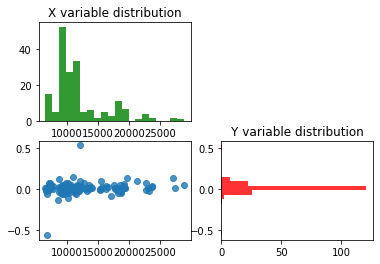

In [27]:
from copulalib.copulalib import Copula
from array import array 

# Data and histograms
def plotData():
    x = (btc_df["Close"]).fillna(0).values
    y = (btc_df['Day_Return']).fillna(0).values
    fig = plt.figure()
    fig.add_subplot(2,2,1)
    plt.hist(x,bins=20,color='green',alpha=0.8,align='mid')
    plt.title('X variable distribution')
    fig.add_subplot(2,2,3)
    plt.scatter(x,y,marker="o",alpha=0.8)
    fig.add_subplot(2,2,4)
    plt.title('Joint X,Y')
    plt.hist(y,bins=20,orientation='horizontal',color='red',alpha=0.8,align='mid')
    plt.title('Y variable distribution')    
    plt.show()
    
def generateCopulas():
    x = array((btc_df["Close"]).fillna(0).values.tolist())
    y = array((btc_df['Day_Return']).fillna(0).values.tolist())
    fig = plt.figure()
    
    clayton = Copula(x,y,family='clayton')
    uc,vc = clayton.generate_uv(1000)
    fig.add_subplot(2,2,2)
    plt.scatter(uc,vc,marker='.',color='red')
    plt.ylim(0,1)
    plt.xlim(0,1)
    plt.title('Clayton copula')
    plt.show()
    

plotData();

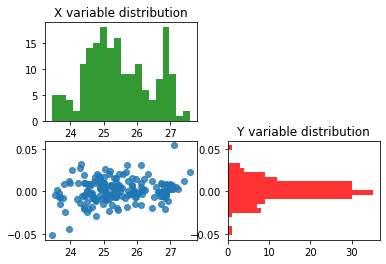

In [28]:
def plotData():
    x = (ety_df["Close"]).fillna(0).values
    y = (ety_df['Day_Return']).fillna(0).values
    fig = plt.figure()
    fig.add_subplot(2,2,1)
    plt.hist(x,bins=20,color='green',alpha=0.8,align='mid')
    plt.title('X variable distribution')
    fig.add_subplot(2,2,3)
    plt.scatter(x,y,marker="o",alpha=0.8)
    fig.add_subplot(2,2,4)
    plt.title('Joint X,Y')
    plt.hist(y,bins=20,orientation='horizontal',color='red',alpha=0.8,align='mid')
    plt.title('Y variable distribution')    
    plt.show()
    
def generateCopulas():
    x = array((ety_df["Close"]).fillna(0).values.tolist())
    y = array((ety_df['Day_Return']).fillna(0).values.tolist())
    fig = plt.figure()
    
    clayton = Copula(x,y,family='clayton')
    uc,vc = clayton.generate_uv(1000)
    fig.add_subplot(2,2,2)
    plt.scatter(uc,vc,marker='.',color='red')
    plt.ylim(0,1)
    plt.xlim(0,1)
    plt.title('Clayton copula')
    plt.show()
    

plotData();

## Category 1 Models: ARMA(2,2), GARCH(1,1)

In [29]:
# For choosing quarterly data
def get_data(df, quarter, column):
    if quarter == 'Q4':
        return df[(df.index > "2020-09-30")][column]
    elif quarter == 'Q3':
        return df.loc[(df.index > "2020-06-30") & (df.index < "2020-10-01")][column]
    elif quarter == 'Q2':
        return df[(df.index > "2020-03-31") & (df.index < "2020-07-01")][column]

In [30]:
# we choose ety_df 
ety_Q2 = get_data(ety_df, "Q2", "Day_Return")
ety_Q3 = get_data(ety_df, "Q3", "Day_Return")
ety_Q4 = get_data(ety_df, "Q4", "Day_Return")

In [31]:
# we choose ety_df 
btc_Q2 = get_data(btc_df, "Q2", "Day_Return")
btc_Q3 = get_data(btc_df, "Q3", "Day_Return")
btc_Q4 = get_data(btc_df, "Q4", "Day_Return")

In [32]:
gld_Q2 = get_data(gld_df, "Q2", "Day_Return")
gld_Q3 = get_data(gld_df, "Q3", "Day_Return")
gld_Q4 = get_data(gld_df, "Q4", "Day_Return")

In [37]:
import statistics
print("Equity Q2 mean log-return is:", statistics.mean(ety_Q2))
print("Equity Q3 mean log-return is:", statistics.mean(ety_Q3))
print("Equity Q4 mean log-return is:", statistics.mean(ety_Q4))

Equity Q2 mean log-return is: 0.0009371832203837446
Equity Q3 mean log-return is: -0.000597093072560425
Equity Q4 mean log-return is: 0.002368846480934895


In [38]:
print("Bitcoin Q2 mean log-return is:", statistics.mean(btc_Q2))
print("Bitcoin Q3 mean log-return is:", statistics.mean(btc_Q3))
print("Bitcoin Q4 mean log-return is:", statistics.mean(btc_Q4))

Bitcoin Q2 mean log-return is: 0.005636138568787838
Bitcoin Q3 mean log-return is: 0.0026342573822663753
Bitcoin Q4 mean log-return is: 0.01666775170252626


In [39]:
print("Gold Q2 mean log-return is:", statistics.mean(gld_Q2))
print("Gold Q3 mean log-return is:", statistics.mean(gld_Q3))
print("Gold Q4 mean log-return is:", statistics.mean(gld_Q4))

Gold Q2 mean log-return is: 0.0019357100384906367
Gold Q3 mean log-return is: 0.0008987387314168692
Gold Q4 mean log-return is: 5.5411483853268685e-05


In [40]:
#fitting ARMA(2,2) model
def fit_arima(data, exog= None):
    model = ARIMA(data, exog=exog, order=(2,0,2))
    model_fit = model.fit()
    return model_fit

In [41]:
def fit_garch(data, garch_type="GARCH"):
    if garch_type == "TARCH":
        garch = arch.arch_model(data, vol='TGARCH', p=1, o=1, q=1, power=1)
    else:
        garch = arch.arch_model(data, vol=garch_type, p=1, o=0, q=1)
    garch_fitted = garch.fit()
    print(garch_fitted.summary())
    if garch_type != "FIGARCH":
        omega = garch_fitted.params["omega"]
        alpha = garch_fitted.params["alpha[1]"]
        beta = garch_fitted.params["beta[1]"]
        print(f"Unconditional variance: {omega/(1 - alpha - beta)}")
    return garch_fitted

In [42]:
quarter_name = {"Q2": "Quarter 2", "Q3": "Quarter 3", "Q4": "Quarter 4"}

In [43]:
btc_Q2.shape, btc_Q3.shape, btc_Q4.shape

((59,), (63,), (59,))

In [44]:
model = fit_arima(ety_Q2)
return_pred = model.predict(start=ety_Q2.shape[0], end=ety_Q2.shape[0] + ety_Q3.shape[0] - 1).values
signal = np.where(return_pred > 0, 1, -1)
return_Q3 = np.product(ety_Q3 * signal + 1) - 1
return_Q3

C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive paramet

-0.13022074900191116

In [45]:
model = fit_arima(ety_Q3)
return_pred = model.predict(start=ety_Q3.shape[0], end=ety_Q3.shape[0] + ety_Q4.shape[0] - 1).values
signal = np.where(return_pred >0, 1, -1)
return_Q4 = np.product(ety_Q4 * signal + 1) - 1
return_Q4

C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction resul

-0.13285807833627228

In [46]:
(1 + return_Q3) * (1 + return_Q4) - 1

-0.24577794886627946

In [47]:
model = fit_arima(btc_Q2)
return_pred = model.predict(start=btc_Q2.shape[0], end=btc_Q2.shape[0] + btc_Q3.shape[0] - 1).values
signal = np.where(return_pred > 0, 1, -1)
return_Q3 = np.product(btc_Q3 * signal + 1) - 1
return_Q3

C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge.

0.14748531812391286

In [48]:
model = fit_arima(btc_Q3)
return_pred = model.predict(start=btc_Q3.shape[0], end=btc_Q3.shape[0] + btc_Q4.shape[0] - 1).values
signal = np.where(return_pred >0, 1, -1)
return_Q4 = np.product(btc_Q4 * signal + 1) - 1
return_Q4

C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge.

1.5226854752330712

In [49]:
(1 + return_Q3) * (1 + return_Q4) - 1

1.8947445450743952

In [50]:
# Fitting Garch Model
data = btc_Q2
data = data.dropna()
garch_fitted = fit_garch(data, "GARCH")
forecasts = garch_fitted.forecast(horizon=63, reindex=False)
#forecasts = garch_fitted.forecast(horizon=63, method='simulation', simulations=1000)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2057.6894633051816
Iteration:      2,   Func. Count:     15,   Neg. LLF: 8364.327879690207
Iteration:      3,   Func. Count:     21,   Neg. LLF: 20254593.382006835
Iteration:      4,   Func. Count:     27,   Neg. LLF: -44.53640566040372
Iteration:      5,   Func. Count:     33,   Neg. LLF: -59.73568975559939
Iteration:      6,   Func. Count:     39,   Neg. LLF: 46.90515426694333
Iteration:      7,   Func. Count:     45,   Neg. LLF: -70.12895904377423
Iteration:      8,   Func. Count:     50,   Neg. LLF: -69.67183613606363
Iteration:      9,   Func. Count:     56,   Neg. LLF: -70.57625688734657
Iteration:     10,   Func. Count:     62,   Neg. LLF: -70.71535287369464
Iteration:     11,   Func. Count:     67,   Neg. LLF: -70.71538292495688
Iteration:     12,   Func. Count:     72,   Neg. LLF: 974.9001905728838
Optimization terminated successfully    (Exit mode 0)
            Current function value: -70.71538300230992
            Iterat

C:\Users\Admin\anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.01169. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [51]:
print(forecasts.residual_variance.iloc[-3:])

                h.01      h.02      h.03      h.04      h.05      h.06  \
Date                                                                     
2020-06-30  0.002454  0.004901  0.007348  0.009795  0.012242  0.014689   

                h.07      h.08     h.09      h.10  ...      h.54      h.55  \
Date                                               ...                       
2020-06-30  0.017136  0.019583  0.02203  0.024477  ...  0.132142  0.134588   

                h.56      h.57      h.58      h.59      h.60     h.61  \
Date                                                                    
2020-06-30  0.137035  0.139482  0.141929  0.144376  0.146823  0.14927   

                h.62      h.63  
Date                            
2020-06-30  0.151717  0.154164  

[1 rows x 63 columns]


In [52]:
data = btc_Q3
data = data.dropna()
garch_fitted = fit_garch(data, "GARCH")
forecasts = garch_fitted.forecast(horizon=59, reindex=False)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 25325.586035561137
Iteration:      2,   Func. Count:     16,   Neg. LLF: 10.723682639044778
Iteration:      3,   Func. Count:     24,   Neg. LLF: -131.27836997286798
Iteration:      4,   Func. Count:     29,   Neg. LLF: -131.29715303352035
Iteration:      5,   Func. Count:     34,   Neg. LLF: -126.35759438743713
Iteration:      6,   Func. Count:     40,   Neg. LLF: -127.11990861763533
Iteration:      7,   Func. Count:     46,   Neg. LLF: -127.63388495825697
Iteration:      8,   Func. Count:     52,   Neg. LLF: -131.5020495960298
Iteration:      9,   Func. Count:     57,   Neg. LLF: -130.67514405167256
Iteration:     10,   Func. Count:     63,   Neg. LLF: -131.48236881747272
Iteration:     11,   Func. Count:     69,   Neg. LLF: -130.45388038924204
Iteration:     12,   Func. Count:     75,   Neg. LLF: -131.62590047008075
Iteration:     13,   Func. Count:     81,   Neg. LLF: -131.63136319092612
Iteration:     14,   Func. Count:     87,

C:\Users\Admin\anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009069. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [53]:
print(forecasts.residual_variance.iloc[-3:])

                h.01      h.02      h.03      h.04      h.05      h.06  \
Date                                                                     
2020-09-30  0.000978  0.000978  0.000978  0.000979  0.000979  0.000979   

                h.07      h.08      h.09      h.10  ...      h.50      h.51  \
Date                                                ...                       
2020-09-30  0.000979  0.000979  0.000979  0.000979  ...  0.000979  0.000979   

                h.52      h.53      h.54      h.55      h.56      h.57  \
Date                                                                     
2020-09-30  0.000979  0.000979  0.000979  0.000979  0.000979  0.000979   

                h.58      h.59  
Date                            
2020-09-30  0.000979  0.000979  

[1 rows x 59 columns]


## Category 2 Models: VECM, GARCH and CoIntegration

In [54]:
# Using 2 models

model = fit_arima(btc_Q2, ety_Q2)
return_pred = model.predict(exog=ety_Q3, start=btc_Q2.shape[0], end=btc_Q2.shape[0] + btc_Q3.shape[0] - 1).values
signal = np.where(return_pred > 0, 1, -1)
return_Q3 = np.product(btc_Q3 * signal + 1) - 1
return_Q3

C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge.

0.09974798968709386

In [55]:
model = fit_arima(btc_Q3, ety_Q3)
return_pred = model.predict(exog=ety_Q4, start=btc_Q3.shape[0], end=btc_Q3.shape[0] + btc_Q4.shape[0] - 1).values
signal = np.where(return_pred > 0, 1, -1)
return_Q4 = np.product(btc_Q4 * signal + 1) - 1
return_Q4

C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction resul

0.8615922366885527

In [56]:
(1 + return_Q3) * (1 + return_Q4) - 1

1.0472823199153365

In [57]:
model = fit_arima(btc_Q2, pd.concat([ety_Q2, gld_Q2], axis=1))
return_pred = model.predict(exog=pd.concat([ety_Q3, gld_Q3], axis=1), start=btc_Q2.shape[0], end=btc_Q2.shape[0] + btc_Q3.shape[0] - 1).values
signal = np.where(return_pred > 0, 1, -1)
return_Q3 = np.product(btc_Q3 * signal + 1) - 1
return_Q3

C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge.

-0.41684542374790146

In [58]:
model = fit_arima(btc_Q3, pd.concat([ety_Q3, gld_Q3], axis=1))
return_pred = model.predict(exog=pd.concat([ety_Q4, gld_Q4], axis=1), start=btc_Q3.shape[0], end=btc_Q3.shape[0] + btc_Q4.shape[0] - 1).values
signal = np.where(return_pred > 0, 1, -1)
return_Q4 = np.product(btc_Q4 * signal + 1) - 1
return_Q4

C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge.

0.5252887692502664

In [59]:
(1 + return_Q3) * (1 + return_Q4) - 1

-0.11052087410577605

In [60]:
print(coint(ety_Q2, np.array([btc_Q2, gld_Q2]).T))
print(coint(btc_Q2, np.array([ety_Q2, gld_Q2]).T))
print(coint(gld_Q2, np.array([btc_Q2, ety_Q2]).T))

(-9.009886786838846, 1.0156944304581536e-13, array([-4.55225082, -3.89138389, -3.56042834]))
(-7.631244069155397, 8.482040166297197e-10, array([-4.55225082, -3.89138389, -3.56042834]))
(-8.40672988479475, 5.883619338553873e-12, array([-4.55225082, -3.89138389, -3.56042834]))


In [2]:
# The p-value in each case above signifies that the return series in Quarter 2 are cointegrating

## Category 3 Models: VARM

In [61]:
vec_Q2 = np.array([ety_Q2, btc_Q2, gld_Q2]).T
model = VECM(vec_Q2, coint_rank=1)
vecm_res = model.fit()
res = vecm_res.predict(steps=63)
row_sums = res.sum(axis=1)
weights = res / row_sums[:, np.newaxis]
weights

array([[ 0.3039055 ,  0.82756673, -0.13147223],
       [ 0.32094165, -0.01073344,  0.68979179],
       [ 0.21208777,  1.49979789, -0.71188566],
       [-0.20291885,  2.69954302, -1.49662417],
       [ 0.18088223,  3.38632372, -2.56720595],
       [-0.10080642,  3.16358436, -2.06277794],
       [ 0.00987048,  2.52988315, -1.53975363],
       [-0.02685625,  3.01951263, -1.99265637],
       [-0.01870451,  2.94181383, -1.92310932],
       [-0.01730372,  2.78161022, -1.76430649],
       [-0.01861945,  2.90369603, -1.88507658],
       [-0.01769421,  2.87492561, -1.8572314 ],
       [-0.01920038,  2.86452745, -1.84532707],
       [-0.0172872 ,  2.86406531, -1.84677811],
       [-0.01890775,  2.87882514, -1.85991739],
       [-0.01789314,  2.86450408, -1.84661095],
       [-0.01844556,  2.87105828, -1.85261271],
       [-0.01810538,  2.86976142, -1.85165603],
       [-0.01835759,  2.87009574, -1.85173815],
       [-0.018173  ,  2.86911815, -1.85094515],
       [-0.01828939,  2.8702629 , -1.851

In [62]:
vec_Q3 = np.array([ety_Q3, btc_Q3, gld_Q3]).T

In [63]:
return_Q3 = weights * vec_Q3
total_return_Q3 = return_Q3.sum(axis=1)
portfolio_return_Q3 = np.product(total_return_Q3 + 1) - 1
portfolio_return_Q3

0.18771531918562823

In [64]:
print(coint(ety_Q3, np.array([btc_Q3, gld_Q3]).T))
print(coint(btc_Q3, np.array([ety_Q3, gld_Q3]).T))
print(coint(gld_Q3, np.array([btc_Q3, ety_Q3]).T))

(-0.900653458018321, 0.9727450043898902, array([-4.53500554, -3.88148182, -3.55337787]))
(-9.347212419636183, 9.90002470276579e-15, array([-4.53500554, -3.88148182, -3.55337787]))
(-3.2014323597751666, 0.1680589114665484, array([-4.53500554, -3.88148182, -3.55337787]))


In [65]:
# The p-value above signifies that only the Bitcoin return series and combination of equity and gold return series are cointegrating. 
#In other two scenarios we reject the null hypothesis for existance of cointegration

In [66]:
model = VECM(vec_Q3, coint_rank=1)
vecm_res = model.fit()
res = vecm_res.predict(steps=59)
row_sums = res.sum(axis=1)
weights = res / row_sums[:, np.newaxis]
weights

array([[-1.97763650e-01,  8.39190468e-01,  3.58573182e-01],
       [-1.33874486e-01,  3.24377724e-01,  8.09496762e-01],
       [ 4.58705843e-02,  8.09891546e-01,  1.44237870e-01],
       [ 1.11170305e-01,  1.45069806e+00, -5.61868361e-01],
       [ 5.70959502e-02,  8.76650294e-01,  6.62537562e-02],
       [ 6.69665634e-02,  1.00329264e+00, -7.02592047e-02],
       [ 6.05712290e-02,  9.12452555e-01,  2.69762157e-02],
       [ 6.29518977e-02,  9.53516067e-01, -1.64679649e-02],
       [ 6.16937397e-02,  9.27494836e-01,  1.08114245e-02],
       [ 6.22007688e-02,  9.41266556e-01, -3.46732435e-03],
       [ 6.19823274e-02,  9.33014761e-01,  5.00291113e-03],
       [ 6.20539865e-02,  9.37632684e-01,  3.13329886e-04],
       [ 6.20399834e-02,  9.34920738e-01,  3.03927892e-03],
       [ 6.20318594e-02,  9.36475199e-01,  1.49294173e-03],
       [ 6.20456532e-02,  9.35566358e-01,  2.38798904e-03],
       [ 6.20325241e-02,  9.36093796e-01,  1.87368000e-03],
       [ 6.20430817e-02,  9.35784921e-01

In [67]:
vec_Q4 = np.array([ety_Q4, btc_Q4, gld_Q4]).T

In [68]:
return_Q4 = weights * vec_Q4
total_return_Q4 = return_Q4.sum(axis=1)
portfolio_return_Q4 = np.product(total_return_Q4 + 1) - 1
portfolio_return_Q4

1.4225981489052275

In [69]:
(1 + portfolio_return_Q3) * (1 + portfolio_return_Q4) - 1

1.8773569336854843

## Combination Models

In [70]:
# From the portfolio returns we can see that the VECM is the best performing model with highest returns